Пытаюсь подать данные на DNNClassifier (https://www.youtube.com/watch?v=s0JvhHr3r8k) и обучить сеть, 
но переживаю целый ряд проблем

1. Новый датасет оказался полным дном, в нём нет целой кучи данных.
2. Мало данных. РнД пацанов не хватает. Обучаюсь на всех сразу.
3. Набившая оскомину Unable to get element as bytes (https://stackoverflow.com/questions/47918681/internalerror-in-tensorflow-when-trying-to-save-a-checkpoint)

Чтобы её пофиксить: 
- удаляю пробелы
- удаляю символы &, +, ?, русские символы, короче все которые не latin-1
- возможно ещё в запятых проблема.

Ошибки в данных:
- также есть значения '#????!' и 'n/a'
- широко распространенная ошибка -- в ячейке хранится стринг, который пытаемся запроцессить как флоат (Gender)
- в процессе изменения значений в числовые столбцы закрались 'n/a'
- ЗАМЕНИТЬ ЗНАЧЕНИЕ "NA" (Северная Америка)

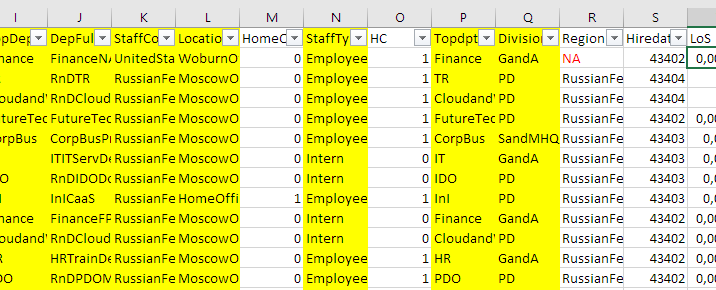

И всё равно не помогает. 
Надо либо сравнивать со сработавшими датасетами и искать в чем ошибка, либо отрезать фичи пока не заработает и выяснять в чем дело. Также есть вариант порезать датасет построчно.


##### TO DO:

1. Проверить фичи - check
2. Локализовать проблему с датасетом - check
3. Устранить её - check
4. Пробовать DNN в разных конфигурациях, следить за результатом - check
5. Попытаться прикрутить обучение на данных из 2019.


Проблема нулевого присижена
https://stackoverflow.com/questions/48061976/precision-is-always-zero-tensorflow-metrics



In [22]:
import tensorflow as tf

from tensorflow.keras import layers


from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from tensorflow.feature_column import bucketized_column

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

tf.enable_eager_execution() #new
print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [23]:
#Preprocessing the data

# AllFiredAreFiredRnD2.6.csv
# 02-02-19-mainstructure2.csv
data = pd.read_csv('02-02-19-mainstructure3halftest.csv', sep=';', encoding='latin-1', low_memory=False)
#datatopivot = data[['EmplId', 'Y', 'M', 'TerminationFact']]
#pivoted = datatopivot.pivot_table(index = ['EmplId', 'Y'], 
#                        columns='M', values='TerminationFact', fill_value=0.0)
#merged = pd.merge(data, pivoted, how='left', on='EmplId')
#result = merged.drop_duplicates(subset='EmplId', keep='first', inplace=False)

#csvname = '14tmp3.csv'
#result.to_csv(path_or_buf= csvname)
#data = result

#csv at the end

data.head()

,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,TerminationFact,Terminationdate,TopDept,DepFull,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
0,2018,10,10606,BerrioAlejandro,Active,0,0,0,9,1,...,47,17010,1,521,5,46,1,0,0,0
1,2018,10,10604,Balandyuk-OpalinskayaYaninaEdvardovna,Active,0,0,0,5,2,...,28,10071,1,998,1,34,1,0,0,0
2,2018,10,10603,ShiyanovVladimirGennadyevich,Active,0,0,0,10,3,...,31,11352,1,1183,17,39,1,0,0,0
3,2018,10,10601,NechiporukArtemMikhaylovich,Active,0,0,0,11,4,...,38,13723,1,829,5,47,1,0,0,0
4,2018,10,10600,ShaykhelislamovDamirIldarovich,Active,0,0,0,12,5,...,34,12545,1,878,3,41,1,0,0,0


In [24]:
data.columns

Index(['Y', 'M', 'EmplId', 'FullnameEng', 'Status', 'VacationDaysCollected',
       'TerminationFact', 'Terminationdate', 'TopDept', 'DepFull',
       'StaffCountry', 'Location', 'HomeOffice', 'StaffTypeName', 'HC',
       'Topdptreorg', 'Division', 'Region', 'Hiredate', 'LoS', 'DaysOfServ',
       'DoB', 'Age', 'Age(years)', 'Age(Days)', 'Gender', 'Grade', 'Manager',
       'SPAN', 'Performance', 'Talent', 'CR', 'CR1000', 'CRgroup',
       'Averageageintheteam', 'Averageageintheteam(Days)', 'Agediffwithteam',
       'Agediffwithteam1000', 'numberofteammates', 'Managersage',
       'AgediffwithManager', 'Differentlocationwithmanager',
       'Overtimehourscumul', 'Overtimehourspermonth'],
      dtype='object')

In [25]:
# Not appropriate for RandForest
#feat_EmplId = tf.feature_column.numeric_column('EmplId')
#feat_FullNameEng = tf.feature_column.categorical_column_with_hash_bucket('FullNameEng',hash_bucket_size=2300)

feat_HomeOffice = tf.feature_column.numeric_column('HomeOffice')
feat_Averageage = tf.feature_column.numeric_column('Averageageintheteam')
feat_Agediffwithteam = tf.feature_column.numeric_column('Agediffwithteam1000')
feat_Grade = tf.feature_column.numeric_column('Grade')
feat_Manager = tf.feature_column.numeric_column('Manager')
feat_SPAN = tf.feature_column.numeric_column('SPAN')
feat_Performance = tf.feature_column.numeric_column('Performance')
feat_Talent = tf.feature_column.numeric_column('Talent')
feat_CR = tf.feature_column.numeric_column('CR')
feat_numberofteammates = tf.feature_column.numeric_column('numberofteammates')
feat_Managerage = tf.feature_column.numeric_column('Managersage')
feat_Differentlocationwithmanager = tf.feature_column.numeric_column('Differentlocationwithmanager')
feat_Overtimehourscumul = tf.feature_column.numeric_column('Overtimehourscumul')
feat_Overtimehourspermonth = tf.feature_column.numeric_column('Overtimehourspermonth')
feat_Location = tf.feature_column.numeric_column('Location')
feat_LoS = tf.feature_column.numeric_column('LoS')
feat_DoB = tf.feature_column.numeric_column('DoB')
feat_Age = tf.feature_column.numeric_column('Age')
feat_HC = tf.feature_column.numeric_column('HC')
feat_AgediffwithManager = tf.feature_column.numeric_column('AgediffwithManager')
feat_Region = tf.feature_column.numeric_column('Region')
feat_Hiredate = tf.feature_column.numeric_column('Hiredate')
feat_StaffTypeName = tf.feature_column.numeric_column('StaffTypeName')
feat_Gender = tf.feature_column.numeric_column('Gender')



bucketized_HomeOffice = bucketized_column(feat_HomeOffice, boundaries=[0,2])
bucketized_Averageage = bucketized_column(feat_Averageage, boundaries=[0,100])
bucketized_Agediffwithteam = bucketized_column(feat_Agediffwithteam, boundaries=[0,1000])
bucketized_Grade = bucketized_column(feat_Grade, boundaries=[0,100])
bucketized_Manager = bucketized_column(feat_Manager, boundaries=[0,100])
bucketized_SPAN = bucketized_column(feat_SPAN, boundaries=[0,100])
bucketized_Performance = bucketized_column(feat_Performance, boundaries=[0,100])
bucketized_Talent = bucketized_column(feat_Talent, boundaries=[0,2])
bucketized_CR = bucketized_column(feat_CR, boundaries=[0,100])
bucketized_numberofteammates = bucketized_column(feat_numberofteammates, boundaries=[0,100])
bucketized_Managerage = bucketized_column(feat_Managerage, boundaries=[0,100])
bucketized_Differentlocationwithmanager = bucketized_column(feat_Differentlocationwithmanager, boundaries=[0,100])
bucketized_Overtimehourscumul = bucketized_column(feat_Overtimehourscumul, boundaries=[0,100])
bucketized_Overtimehourspermonth = bucketized_column(feat_Overtimehourspermonth, boundaries=[0,100])
bucketized_Location = bucketized_column(feat_Location, boundaries=[0,61])
bucketized_AgediffwithManager = bucketized_column(feat_AgediffwithManager, boundaries=[0,100])
bucketized_HC = bucketized_column(feat_HC, boundaries=[0,2])
bucketized_Age = bucketized_column(feat_Age, boundaries=[0,100])
bucketized_DoB = bucketized_column(feat_DoB, boundaries=[20500,37000])
bucketized_LoS = bucketized_column(feat_LoS, boundaries=[0,22])
bucketized_Region = bucketized_column(feat_Region, boundaries=[0,7])
bucketized_Hiredate = bucketized_column(feat_Hiredate, boundaries=[35000,44000])
bucketized_StaffTypeName = bucketized_column(feat_StaffTypeName, boundaries=[0,2])
bucketized_Gender = bucketized_column(feat_Gender, boundaries=[0,2])



# 
# feat_cols = [feat_Y,feat_M,
#              feat_VacationDaysCollected,feat_TopDept,
#              feat_StaffCountry,feat_Location,feat_HomeOffice,
#              feat_StaffTypeName,feat_TopDptReorg,
#              feat_Region,feat_Hiredate,bucketized_LoS,bucketized_DoB,bucketized_Age,
#              bucketized_AgediffwithManager,bucketized_HC]


# 
# feat_DepFull = tf.feature_column.categorical_column_with_hash_bucket('DepFull',hash_bucket_size=470)
# feat_VacationDaysCollected = tf.feature_column.numeric_column('VacationDaysCollected')
# feat_TopDept = tf.feature_column.categorical_column_with_hash_bucket('TopDept',hash_bucket_size=30)
# feat_StaffCountry = tf.feature_column.categorical_column_with_hash_bucket('StaffCountry',hash_bucket_size=50)
# # feat_TopDptReorg = tf.feature_column.categorical_column_with_hash_bucket('Topdptreorg',hash_bucket_size=35)
# 

# feat_cols = [bucketized_Age,
#              bucketized_HomeOffice,bucketized_Location,
#              bucketized_HC,bucketized_Region,bucketized_Hiredate,
#              bucketized_LoS,bucketized_DoB,bucketized_Gender,
#              bucketized_Grade]

# feat_cols = [bucketized_Age,bucketized_Grade,
#              bucketized_LoS,bucketized_DoB,bucketized_Gender,
#              bucketized_Manager,bucketized_Talent,bucketized_CR,
#              bucketized_numberofteammates,bucketized_Managerage,
#              bucketized_Differentlocationwithmanager,bucketized_StaffTypeName,
#              bucketized_Agediffwithteam,bucketized_AgediffwithManager,
#              bucketized_Averageage]

feat_cols = [bucketized_Age,
             bucketized_HomeOffice,bucketized_Location,
             bucketized_HC,bucketized_Region,bucketized_Hiredate,
             bucketized_LoS,bucketized_DoB,bucketized_Gender,
             bucketized_Grade,bucketized_Manager,bucketized_SPAN,
             bucketized_Performance,bucketized_Talent,bucketized_CR,
             bucketized_numberofteammates,bucketized_Managerage,
             bucketized_Differentlocationwithmanager,bucketized_StaffTypeName,
             bucketized_Agediffwithteam,bucketized_AgediffwithManager,
             bucketized_Averageage]

In [26]:
x_data = data.drop('TerminationFact',axis=1)
#x_data = data
labels = data['TerminationFact']

x_data.head()


,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,Terminationdate,TopDept,DepFull,StaffCountry,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
0,2018,10,10606,BerrioAlejandro,Active,0,0,9,1,1,...,47,17010,1,521,5,46,1,0,0,0
1,2018,10,10604,Balandyuk-OpalinskayaYaninaEdvardovna,Active,0,0,5,2,2,...,28,10071,1,998,1,34,1,0,0,0
2,2018,10,10603,ShiyanovVladimirGennadyevich,Active,0,0,10,3,2,...,31,11352,1,1183,17,39,1,0,0,0
3,2018,10,10601,NechiporukArtemMikhaylovich,Active,0,0,11,4,2,...,38,13723,1,829,5,47,1,0,0,0
4,2018,10,10600,ShaykhelislamovDamirIldarovich,Active,0,0,12,5,2,...,34,12545,1,878,3,41,1,0,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.2,random_state=101)
##X_train2, X_test2, y_train2, y_test2 = train_test_split(x_data,labels, test_size=0.99, random_state=101)


input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)

#BoostedTreesClassifier
#BoostedTreesRegressor

# model = tf.estimator.BoostedTreesClassifier(feature_columns=feat_cols, 
#     n_batches_per_layer=100, 
#     n_trees=15000, 
#     label_dimension = labels,
#     max_depth=5,
#     learning_rate=0.1)

# boosted_trees_regressor(feature_columns, n_batches_per_layer,
#   model_dir = NULL, label_dimension = 1L, weight_column = NULL,
#   n_trees = 100L, max_depth = 6L, learning_rate = 0.1,
#   l1_regularization = 0, l2_regularization = 0, tree_complexity = 0,
#   min_node_weight = 0, config = NULL)

model_dir ="tmp\modeldirs"
model = tf.estimator.DNNClassifier(
    feature_columns=feat_cols,
    model_dir=model_dir, 
    hidden_units=[25, 32, 16, 8, 4, 2],
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.1),n_classes=2)


#### WORKING 
# model_dir ="tmp\modeldirs"
# model = tf.estimator.DNNClassifier(
#     feature_columns=feat_cols,
#     model_dir=model_dir, 
#     hidden_units=[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2],optimizer=tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.1,
#       l1_regularization_strength=0.001
#     ))



#model = tf.estimator.BoostedTreesClassifier(feature_columns=feat_cols, n_batches_per_layer=100,
#  n_trees = 15000, max_depth = 10, n_classes=2,
#  learning_rate = 0.1, l1_regularization = 0, l2_regularization = 0,
#  tree_complexity = 0, min_node_weight = 0)

#Instead Of:
#model = tf.estimator.LinearRegressor(feature_columns=feat_cols)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp\\modeldirs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C818CDDA0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
model.train(input_fn=input_func,steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into tmp\modeldirs\model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:global_step/sec: 335.343
INFO:tensorflow:loss = 6.764822, step = 101 (0.302 sec)
INFO:tensorflow:global_step/sec: 412.625
INFO:tensorflow:loss = 7.00893, step = 201 (0.239 sec)
INFO:tensorflow:global_step/sec: 366.291
INFO:tensorflow:loss = 7.974912, step = 301 (0.272 sec)
INFO:tensorflow:global_step/sec: 379.434
INFO:tensorflow:loss = 6.6352434, step = 401 (0.264 sec)
INFO:tensorflow:global_step/sec: 366.769
INFO:tensorflow:loss = 6.7881546, step = 501 (0.273 sec)
INFO:tensorflow:global_step/sec: 387.042
INFO:tensorflow:loss = 6.7333136, step = 601 (0.258 sec)
INFO:tensorflow:global_step/sec: 386.223
INFO:tensorflow:loss = 6

In [29]:
results = model.evaluate(eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-03-19:22:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp\modeldirs\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-03-19:22:10
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.4588015, accuracy_baseline = 0.5411985, auc = 0.5, auc_precision_recall = 0.72940075, average_loss = 0.69316375, global_step = 5000, label/mean = 0.4588015, loss = 6.897195, precision = 0.4588015, prediction/mean = 0.5000996, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: tmp\modeldirs\model.ckpt-5000


In [30]:
results

{'accuracy': 0.4588015,
 'accuracy_baseline': 0.5411985,
 'auc': 0.5,
 'auc_precision_recall': 0.72940075,
 'average_loss': 0.69316375,
 'label/mean': 0.4588015,
 'loss': 6.897195,
 'precision': 0.4588015,
 'prediction/mean': 0.5000996,
 'recall': 1.0,
 'global_step': 5000}

In [31]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=10,num_epochs=1,shuffle=False)

In [32]:
predictions = model.predict(pred_input_func)

In [33]:
my_pred = list(predictions)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp\modeldirs\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [34]:
my_pred

[{'logits': array([0.00040224], dtype=float32),
  'logistic': array([0.50010055], dtype=float32),
  'probabilities': array([0.49989945, 0.50010055], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.00040224], dtype=float32),
  'logistic': array([0.50010055], dtype=float32),
  'probabilities': array([0.49989945, 0.50010055], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.00040224], dtype=float32),
  'logistic': array([0.50010055], dtype=float32),
  'probabilities': array([0.49989945, 0.50010055], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.00040224], dtype=float32),
  'logistic': array([0.50010055], dtype=float32),
  'probabilities': array([0.49989945, 0.50010055], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logit

In [35]:
dfxtest = pd.DataFrame(X_test)
dfxtest.to_csv("02-02-19-DNNres6-weekfin.csv")

X_test

,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,Terminationdate,TopDept,DepFull,StaffCountry,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
642,2018,10,9865,KonashkovanataliyaSergeevna,Active,23,0,24,206,2,...,27,9801,1,808,5,40,1,1,0,0
6717,2018,3,1792,DongChensheng,Active,0,0,1,410,32,...,32,11770,1,1098,37,40,1,1,0,0
375,2018,10,10186,SayginartemAlexeevich,Active,14,0,18,275,2,...,27,9736,1,976,3,35,1,0,0,0
3657,2018,10,2865,AlDarwishZaher,Active,0,0,19,36,18,...,36,13027,1,1088,5,39,1,0,0,0
7332,2018,2,1004,YampolskyBorisMarkovich,Active,70,0,1,606,2,...,30,10885,1,1148,24,29,1,0,0,0
7209,2018,2,5195,PlyushchArtemAndreevich,Active,14,0,13,1069,2,...,31,11269,1,922,2,41,1,0,0,0
7814,2018,1,6011,VasilkovDmitryAlexandrovich,Active,7,0,1,348,2,...,33,12197,1,703,10,33,1,0,0,0
7892,2018,1,4417,UskovDmitryYuryevich,Active,4,0,1,1047,2,...,34,12532,1,1044,7,38,1,0,0,0
681,2018,10,9820,KuznetsovAndreySergeevich,Active,18,0,15,41,2,...,34,12512,1,985,5,44,1,1,0,0
309,2018,10,10256,RyazantsovDmitryIgorevich,Active,11,0,13,6,2,...,26,9330,1,888,20,30,1,0,0,0


In [36]:
for _ in my_pred:
    print(_)
    
dfpred = pd.DataFrame(my_pred)
dfpred.to_csv("02-02-19-DNNres6res-weekfin2.csv")

{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), '

{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), '

{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), '

{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), 'logistic': array([0.50010055], dtype=float32), 'probabilities': array([0.49989945, 0.50010055], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object)}
{'logits': array([0.00040224], dtype=float32), '